# PCA-GAN
We use CNN-GAN, the PCA is applied to  data.
The generator model generates samples from latent space to the PCA-space, the discriminator model distinguishes real and fake samples in the PCA-space. The inverse PCA transformation is used after generation in order to represent samples from the PCA-space to the initial space.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
import random
import torch.autograd as autograd
import torch.nn.functional as F

import torch.autograd as autograd
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

random_seed = 99
torch.manual_seed(random_seed)
random.seed(random_seed)
DEVICE = torch.device('cpu')

In [ ]:
seq_len = 256 # dimensionality of the PCA-space
random_dim = 32 # the latent space dimensionality
lr = 1e-4 # learning rate
epochs = 100 
batch_size = 128

## 1. Preprocessing

In [3]:
pulses = pickle.load(open('/Users/nzaretski/Desktop/gerda/CNN_GAN_Ge/data/raw/data.pkl','rb'))
pulses = pulses.astype(float)

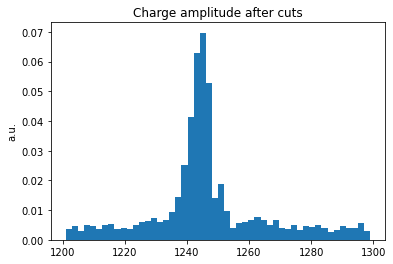

In [5]:
plt.hist(np.max(pulses, axis = 1) - np.min(pulses, axis = 1), bins = 50, density=True)
plt.title('Charge amplitude after cuts')
plt.ylabel('a.u.')
plt.show()

Text(0, 0.5, 'a.u.')

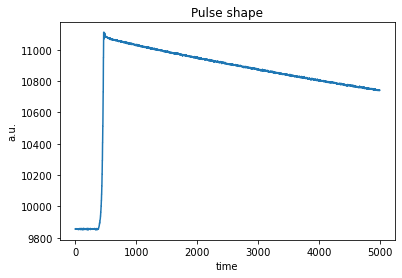

In [6]:
plt.plot(pulses[1])
plt.title('Pulse shape')
plt.xlabel('time')
plt.ylabel('a.u.')

In [6]:
scaler = StandardScaler()
pulses = scaler.fit_transform(pulses) 

pca = PCA(n_components=seq_len)
pulses = pca.fit_transform(pulses)

In [7]:
pickle.dump(scaler, open('scaler_pca.pkl','wb'))
pickle.dump(pca, open('pca_pca.pkl','wb'))

In [7]:
train_data_length = pulses.shape[0]
train_data = torch.zeros((train_data_length, pulses.shape[1]))
train_data = torch.tensor(pulses, dtype=torch.float)
train_labels = torch.zeros(train_data_length, 1)

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [10]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

## 2. Models

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.seq_len = seq_len
        self.model = nn.Sequential(            
            nn.Conv1d(self.seq_len, self.seq_len // 2, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 2, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 4, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(self.seq_len // 8, self.seq_len // 16, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 16, 1, 1, bias=False),
        )
    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return torch.sigmoid(output.squeeze(-1))

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.seq_len = seq_len
        self.random_dim = random_dim
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.random_dim, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 4, self.seq_len // 2, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 2),
            nn.ReLU(True),
            
            nn.ConvTranspose1d(self.seq_len // 2, self.seq_len, 1, bias=False)
      )
    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)
        return output.squeeze(-1)

#  Minimax

In [14]:
netD = Discriminator().to(DEVICE)
netG = Generator().to(DEVICE)
criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)

In [16]:
G_losses = []
D_losses = []

for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):
        # real samples
        x = x.to(DEVICE)
        real_samples_labels = torch.ones((batch_size, 1))
        # real samples' labels = 1
        real_samples_labels = real_samples_labels.to(DEVICE)
        
        # generated (fake) samples
        latent_space_samples = torch.randn((batch_size, random_dim))
        latent_space_samples = latent_space_samples.to(DEVICE)
        generated_samples = netG(latent_space_samples)
        # fake samples' labels = 0
        generated_samples_labels = torch.zeros((batch_size, 1))
        generated_samples_labels = generated_samples_labels.to(DEVICE)
        
        all_samples = torch.cat((x, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        ## training the discriminator
        netD.zero_grad()
        output_discriminator = netD(all_samples)
        
        errD = criterion(output_discriminator, all_samples_labels)
        errD.backward()
        optimizerD.step()
        
        ## training the generator
        latent_space_samples = torch.randn(batch_size, random_dim)
        latent_space_samples = latent_space_samples.to(DEVICE)
        netG.zero_grad()
        generated_samples = netG(latent_space_samples)
        outputDG = netD(generated_samples)
        errG = criterion(outputDG, real_samples_labels)
        errG.backward()
        optimizerG.step()
        
        G_losses.append(errG.item()) 
        D_losses.append(errD.item())
    
        
    if (epoch % 5 == 0):
            print(f"Epoch{epoch} Loss D.: {errD}" "||" 
              f"Loss G.: {errG}")

Epoch0 Loss D.: 0.5446690320968628||Loss G.: 0.573867917060852
Epoch5 Loss D.: 0.3832833170890808||Loss G.: 0.5600488781929016
Epoch10 Loss D.: 0.2947729527950287||Loss G.: 0.5520117878913879
Epoch15 Loss D.: 0.26209941506385803||Loss G.: 0.530208170413971
Epoch20 Loss D.: 0.24329623579978943||Loss G.: 0.5217076539993286
Epoch25 Loss D.: 0.21450410783290863||Loss G.: 0.511107861995697
Epoch30 Loss D.: 0.1953262835741043||Loss G.: 0.4924214780330658
Epoch35 Loss D.: 0.17634934186935425||Loss G.: 0.48709163069725037
Epoch40 Loss D.: 0.1626826971769333||Loss G.: 0.46796298027038574
Epoch45 Loss D.: 0.1470693051815033||Loss G.: 0.46361613273620605
Epoch50 Loss D.: 0.13524127006530762||Loss G.: 0.4471771717071533
Epoch55 Loss D.: 0.12355910241603851||Loss G.: 0.4398009479045868
Epoch60 Loss D.: 0.1137547418475151||Loss G.: 0.4222109615802765
Epoch65 Loss D.: 0.1046956330537796||Loss G.: 0.42223018407821655
Epoch70 Loss D.: 0.09588469564914703||Loss G.: 0.4177846312522888
Epoch75 Loss D.: 0.

In [17]:
torch.save(netG.state_dict(), 'generator_pca.pth')

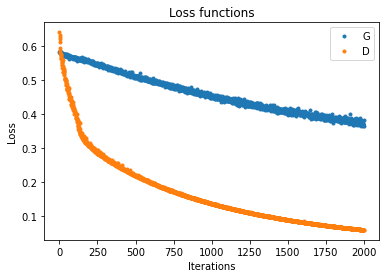

In [18]:
fig = plt.figure()
plt.plot(G_losses, '.', label='G')
plt.plot(D_losses, '.',  label='D')
plt.title('Loss functions')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
fig.savefig('losses.png')

## 2. First check

In [19]:
netG = Generator() 
netG.load_state_dict(torch.load("generator_pca.pth"))

pca = pickle.load(open('pca_pca.pkl','rb'))
scaler = pickle.load(open('scaler_pca.pkl','rb'))

In [20]:
x = torch.randn(10, random_dim)

In [21]:
gen = netG(x).detach()
gen = pca.inverse_transform(gen) # back to 5000 points
gen = scaler.inverse_transform(gen)

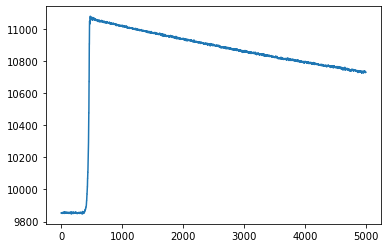

In [22]:
plt.plot(gen[0])
plt.xlabel('time')
#looks similar